# Comparing Models in scBIVI

This notebook compares different physical assumptions, visualizes batch-effects, tests distributions with synthetic data sampled from custom distributions. 

In [1]:
%%capture
%pip install scanpy
%pip install scvi-tools==0.8.1
%pip install loompy
%pip install leidenalg

Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.2
     |████████████████████████████████| 13.1 MB 8.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9638f15a90>)

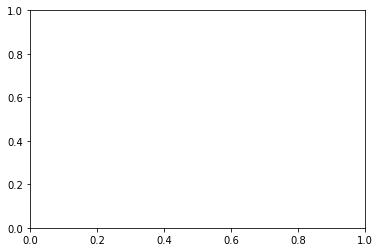

In [2]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3 -q

import matplotlib.pyplot as plt
plt.subplots()

In [3]:

# check GPU availability
import torch 
import torch.nn as nn
import torch.nn.functional as F
memory_used = torch.cuda.memory_allocated()
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


In [4]:
# System
import os, pathlib, time, gc
import sys
sys.path.insert(0,'/content/drive/My Drive/scBIVI_mc/scBIVI/')

# Math
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Plots
import matplotlib
import matplotlib.colors as colors
import seaborn as sns

# scvi
import anndata
import scvi
import pandas

In [5]:
# mount to drive and change directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI/

Mounted at /content/drive
/content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI


In [6]:
# scbivi scripts
from scBIVI import scBIVI
from analysis import calculate_accuracy, \
                     plot_corr_comparison, \
                     jaccard_index_split, \
                     knn_overlap


# Import Custom Distributions

In [7]:
from custom_distributions import log_prob_MMNB, log_prob_nnNB, log_prob_poisson, log_prob_direct, log_MMNB_same_mean
import reformat_model

# Load in data 

In [ ]:
name = 'bursty_3ct'
adata = anndata.read_loom(f'./data/synthetic_data/{name}.loom')

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

adata.var_names_make_unique()

In [ ]:
# outdir = 'out/pbmc_10k_v3'
# datadir = os.path.join(outdir,'data/preprocessed.h5ad')

# adata = anndata.read_h5ad(datadir)
# if 'gene_name' in adata.var.columns:
#     adata.var_names = adata.var['gene_name'].to_list()

# adata.var_names_make_unique()

In [ ]:
adata

AnnData object with n_obs × n_vars = 11581 × 5428
    obs: 'barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Spliced'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'Cluster', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
adata.obs['Cluster'] = adata.obs['leiden']

In [ ]:
# Set up train/test data splits with 5-fold split
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
skf_splits = skf.split(adata, adata.obsm['Cluster'])

In [ ]:
# Use last of the K-fold splits
for k, (train_index, test_index) in enumerate(skf_splits):
  pass

-----


# AND TRAIN

The following seed settings work:
```
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)
```

Define the model setups.

In [ ]:
def compare_setups(adata, setups, results_dict, hyperparameters):
  ''' Runs scBIVI for listed setups in setups given hyperparameters, stores outputs in results_dict. 
  ''' 

  lr = hyperparameters['lr']
  n_epochs = hyperparameters['n_epochs']
  n_hidden = hyperparameters['n_hidden']
  n_layers = hyperparameters['n_layers']
  
  for setup in setups:
      
    print(setup)
    method,n_latent,constant = setup.split("-")
    n_latent = int(n_latent)

    adata_in = adata.copy()
    scvi.data.setup_anndata(adata_in, layer="counts")


    if len(train_index)%2 !=0:
      this_train_index = train_index[:-1]
    else:
      this_train_index = train_index
    train_adata, test_adata = adata_in[this_train_index], adata_in[test_index]
    train_adata = train_adata.copy()


    ## Set model parameters
    model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
    #model_args.update(additional_kwargs)

    ## Create model
    if method == 'MMNB':
        custom_dist = lambda x,mu1,mu2,theta : log_prob_MMNB(x,mu1,mu2,theta,THETA_IS = constant)
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'Direct':
        custom_dist = lambda x,mu1,mu2,theta : log_prob_direct(x,mu1,mu2,theta,THETA_IS = constant)
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'NBcorr':
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == 'NBuncorr':
        model = scBIVI(train_adata,mode='uncorr',**model_args)
    elif method == 'Poisson':
        custom_dist = lambda x,mu1,mu2,theta : log_prob_poisson(x,mu1,mu2,theta,THETA_IS = constant)
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == 'nnNB':
        custom_dist = lambda x,mu1,mu2,theta : log_prob_nnNB(x,mu1,mu2,theta,THETA_IS = constant)
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'Test':
        custom_dist = lambda x,mu1,mu2,theta : log_MMNB_same_mean(x,mu1,mu2,theta,THETA_IS = constant)
        model = scBIVI(train_adata,mode='custom',**model_args)
    else:
        raise Exception('Input valid scVI model')

    ## Train model
    start = time.time()
    model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    results_dict[setup]['compute'].append([runtime,memory_used])

    ## Check train history
    df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                  'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
    df_history = pd.DataFrame(df_history)
    df_history = pd.DataFrame(df_history.stack())
    df = df_history
    df.reset_index(inplace=True)
    df.columns = ['Epoch','Loss Type', 'Loss']
    results_dict[setup]['df_history'] = df

    ## Get reconstruction loss on test data
    test_error  = model.get_reconstruction_error(test_adata)
    train_error = model.get_reconstruction_error(train_adata)
    results_dict[setup]['recon_error'].append(np.array([train_error,test_error]))


    if 'params' in results_dict[setup].keys():
      
      results_dict[setup]['params'] = model.get_likelihood_parameters(adata_in)

    ## Extract the embedding space for scVI
    X_out = model.get_latent_representation(test_adata)
    X_out_full = model.get_latent_representation(adata_in)

    adata.obsm[f'X_{method}'] = X_out_full

    #### Validation with cluster accuracy based on labels
    ## Iterate through ground truth labels based on different approach
    if 'Cluster' in results_dict[setup].keys():
      y = test_adata.obs['Cluster']
      y = np.array(y.tolist())

      score_dict = calculate_accuracy(X_out,y)
      results_dict[setup]['Cluster'].append(score_dict)

    del model
    torch.cuda.empty_cache()
    gc.collect()

  return(results_dict)

# Compare Assumptions

Nascent shape, mature shape, or burst size constant. Does it make a difference? 


In [ ]:
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)


# Hyper-parameters
hyperparameters = { 'lr'       : 1e-3,
        'n_epochs' : 10, 
        'n_hidden' : 1024,
        'n_layers' : 3 }

z  = 3
z1 = 6
z2 = 10
constant = 'NAS_SHAPE'
constant1 = 'NAS_SHAPE'
constant2 = 'NASE_SHAPE'
setups = [f'MMNB-{z}-{constant}',
          f'Direct-{z}-{constant}',
          f'nnNB-{z}-{constant}',
          f'NBcorr-{z}-{constant}',
          f'NBuncorr-{z}-{constant}',
          f'Poisson-{z}-{constant}',
          f'Test-{z1}-{constant}',
          f'MMNB-{z1}-{constant1}',
          f'Direct-{z1}-{constant1}',
          f'nnNB-{z1}-{constant1}',
          f'NBcorr-{z1}-{constant1}',
          f'NBuncorr-{z1}-{constant1}',
          f'Poisson-{z1}-{constant1}',
          f'Test-{z1}-{constant1}',
          f'MMNB-{z2}-{constant2}',
          f'Direct-{z2}-{constant2}',
          f'nnNB-{z2}-{constant2}',
          f'NBcorr-{z2}-{constant2}',
          f'NBuncorr-{z2}-{constant2}',
          f'Poisson-{z2}-{constant2}',
          f'Test-{z2}-{constant2}',
          ]

# setups = ['nnNB-10']

metrics_list = ['recon_error','latent_embedding','compute','df_history','Cluster']
results_dict_NAS_SHAPE = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

In [ ]:
results_dict_NAS_SHAPE = compare_setups(adata, setups, results_dict_NAS_SHAPE, hyperparameters)

# Plot Training/Testing Loss, Accuracy

In [ ]:
fig, ax = plt.subplots(3,3,figsize= (9,9))


for i,setup in enumerate(setups):
  if i <= 3:
    k = i
    l = 0
  else:
    k = abs(3-i)
    l = 1

  if i == 0:
    legend = True
  else:
    legend = False
  sns.lineplot(data = results_dict[setup]['df_history'],x='Epoch',y='Loss',hue='Loss Type',ax=ax[k,l],legend=legend)
  ax[k,l].set_title(f'Setup: {setup}')

plt.tight_layout()

In [12]:
def plot_recon_loss(results_dict):
  setups = list(results_dict.keys())
  df_plot = pd.concat([pd.DataFrame({"Train": -np.array(r['recon_error'])[:,0],
                                   "Test": -np.array(r['recon_error'])[:,1],
                                   'Setup': key}) for key,r in results_dict.items()])

  df_plot['KFold'] = df_plot.index
  df_plot.reset_index(drop=True)



  fig,ax=plt.subplots()
  _ = sns.barplot(data=df_plot, x='Setup', y='Test', hue='Setup', dodge=False, ax=ax)
  ax.get_legend().remove()
  plt.title('Testing Reconstruction Error')
  plt.xticks(rotation=45)
  return(df_plot)
  # print(df_plot.groupby("Setup").mean())



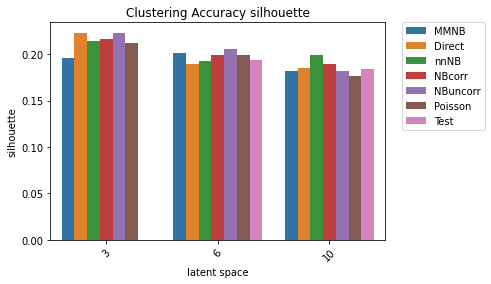

In [ ]:
#### Plot clustering accuracy
metric_ = 'silhouette'
# iterate through different cluster methods
results_dict = results_dict_NAS_SHAPE
df_plot = pd.concat([pd.DataFrame({'NMI': np.array(item[1]['Cluster'][0]['NMI']),
                                   'ARI': np.array(item[1]['Cluster'][0]['ARI']),
                                   'silhouette': np.array(item[1]['Cluster'][0]['silhouette']),
                                   'Setup': item[0].split('-')[0],
                                   'latent space' : item[0].split('-')[1],
                                   'Constant' : item[0].split('-')[2]},index=[i]) for i,item in enumerate(results_dict_NAS_SHAPE.items())])


fig,ax=plt.subplots()
_ = sns.barplot(data=df_plot, x='latent space', y=f'{metric_}', hue='Setup', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.title(f'Clustering Accuracy {metric_}');

# UMAPs !!!



I know they are hated, but let us just visualize the clustering each different method uses. 

In [ ]:
import scanpy as sc
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
# first, look at UMAP of leiden clustering on top 40 PCA components
adata

AnnData object with n_obs × n_vars = 7896 × 64570
    obs: 'Cluster', 'ID_barcode', 'Sex', 'barcode', 'donor', 'library_id', 'obs_names', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'Spliced', 'gene_id', 'gene_name', 'var_names'
    uns: '_scvi'
    obsm: 'X_MMNB', 'X_Direct', 'X_nnNB', 'X_NBcorr', 'X_NBuncorr', 'X_Poisson', 'X_Test'
    layers: 'counts'

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata,color='Cluster')

Z=6, Method: MMNB


TypeError: ignored

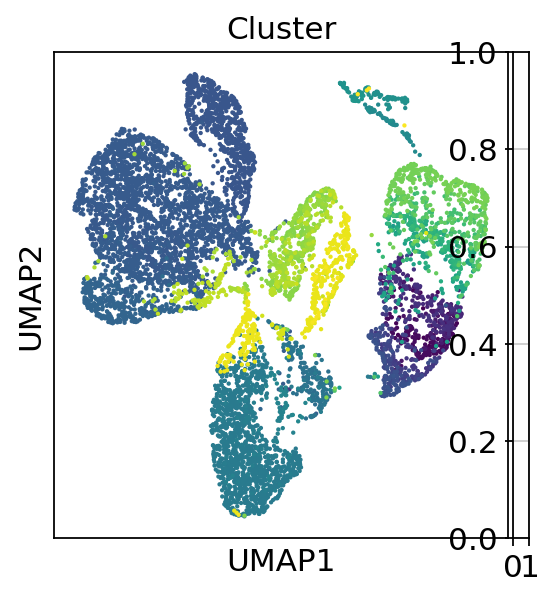

In [ ]:
# UMAP using different distributions

for setup in setups:
  method,n_latent = setup.split("-")
  sc.pp.neighbors(adata, use_rep=f"X_{method}")
  sc.tl.umap(adata)
  print(f"Z={n_latent}, Method: {method}")
  sc.pl.umap(adata,
           color="Cluster")

Z=6, Method: MMNB


TypeError: ignored

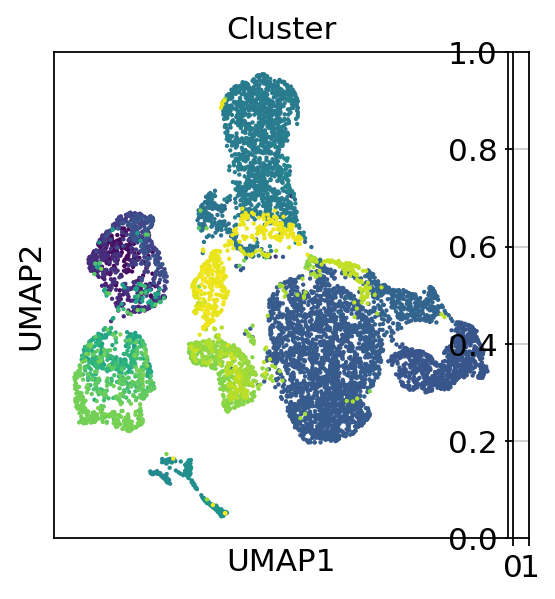

In [ ]:
sc.pp.neighbors(adata, use_rep=f"X_Direct")
sc.tl.umap(adata)
print(f"Z={n_latent}, Method: MMNB")
sc.pl.umap(adata,
           color="Cluster")

# Synthetic Data



1. Constitutive distribution (uncorrelated for spliced, unspliced)
2. NB distributed (uncorrelated for spliced, unspliced)




In [47]:
name = 'bursty_5ct'
adata = anndata.read_loom(f'./data/synthetic_data/{name}')

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

adata.var_names_make_unique()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [48]:
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)


n_layers = 3
n_hidden = 1024
n_epochs = 10
lr = 1e-3


z  = 3

setups = [f'MMNB-{z}',
          f'Direct-{z}',
          f'nnNB-{z}',
          f'NBcorr-{z}',
          f'NBuncorr-{z}',
          f'Poisson-{z}',
          f'Test-{z}'
          ]

# setups = ['nnNB-10']

metrics_list = ['recon_error','latent_embedding','compute','df_history','params']
results_dict_nb = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

In [49]:
for setup in setups:
      
    print(setup)
    method,n_latent = setup.split("-")
    n_latent = int(n_latent)

    adata_in = adata.copy()
    scvi.data.setup_anndata(adata_in, layer="counts")

    train_adata = adata_in[:]
    test_adata = adata_in[:]

    train_adata = train_adata.copy()


    ## Set model parameters
    model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
    #model_args.update(additional_kwargs)

    ## Create model
    if method == 'MMNB':
        custom_dist = log_prob_MMNB
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'Direct':
        custom_dist = log_prob_direct
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'NBcorr':
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == 'NBuncorr':
        model = scBIVI(train_adata,mode='uncorr',**model_args)
    elif method == 'Poisson':
        custom_dist = log_prob_poisson
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == 'nnNB':
        custom_dist = reformat_model.log_prob_nnNB
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'Test':
        custom_dist = log_MMNB_same_mean
        model = scBIVI(train_adata,mode='custom',**model_args)
    else:
        raise Exception('Input valid scVI model')

    ## Train model
    start = time.time()
    model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    results_dict_nb[setup]['compute'].append([runtime,memory_used])

    ## Check train history
    df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                  'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
    df_history = pd.DataFrame(df_history)
    df_history = pd.DataFrame(df_history.stack())
    df = df_history
    df.reset_index(inplace=True)
    df.columns = ['Epoch','Loss Type', 'Loss']
    results_dict_nb[setup]['df_history'] = df

    ## Get reconstruction loss on test data
    test_error  = model.get_reconstruction_error(test_adata)
    train_error = model.get_reconstruction_error(train_adata)
    results_dict_nb[setup]['recon_error'].append(np.array([train_error,test_error]))


    # ## GET PARAMS -- this is an interesting one :D 
    results_dict_nb[setup]['params'] = model.get_likelihood_parameters(adata_in)

    ## Extract the embedding space for scVI
    X_out = model.get_latent_representation(train_adata)
    X_out_full = model.get_latent_representation(adata_in)

    adata.obsm[f'X_{method}'] = X_out_full

    del model
    torch.cuda.empty_cache()
    gc.collect()

MMNB-3
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 1003 cells, 4000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs                                

,Train,Test,Setup,KFold
0,6.757677e+14,6.754694e+14,MMNB-3,0
0,2.340926e+16,2.282911e+16,Direct-3,0
0,5.460854e+14,5.460854e+14,nnNB-3,0
0,4.076028e+14,1.025478e+14,NBcorr-3,0
0,4.975810e+13,5.076726e+13,NBuncorr-3,0
0,7.423094e+14,7.428063e+14,Poisson-3,0
0,9.291357e+14,9.291357e+14,Test-3,0


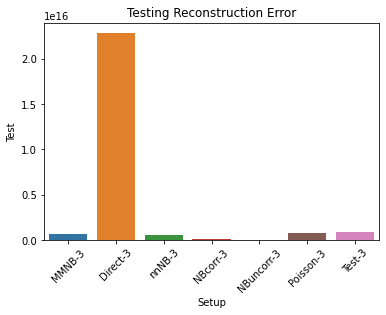

In [50]:
df_plot = plot_recon_loss(results_dict_nb)
df_plot

In [51]:
# number of cells per cell type

cells_per_ct = [len(adata[adata.obs['Cell Type'] == i ]) for i in list(adata.obs['Cell Type'].unique())]

cell_types = list(adata.obs['Cell Type'].unique())

average_mu_dict = {setup:{ CT : [] for CT in cell_types} for setup in setups}

for i, setup in enumerate(setups):
  params_ = results_dict_nb[setup]['params']
  means_ = params_['mean']
    
  for j,ct in enumerate(cell_types):
    means_ct_ = np.mean(means_[ int(np.sum(cells_per_ct[:j])) : int(np.sum(cells_per_ct[:j+1])), : ],axis=0)
    average_mu_dict[setup][f'CT{j}'] = means_ct_
                   

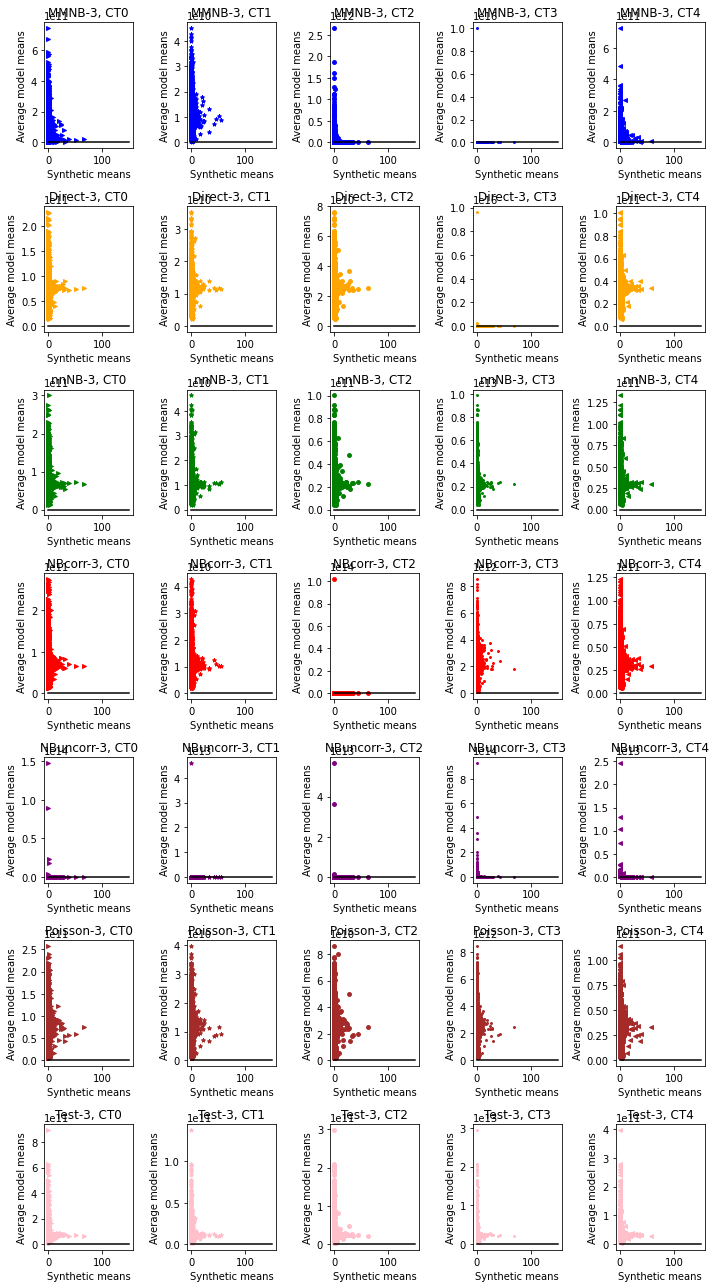

In [56]:
# NOW, plot and see which best reconstructed the poisson means for each cell type (although dispersion might be better than average mean)...
synthetic_params = np.load('./data/synthetic_data/bursty_5ct_params.npy')
synthetic_means_unspliced = 1/(10**synthetic_params[:,:,0])
synthetic_means_spliced = 1/(10**synthetic_params[:,:,1])


colors = ['blue','orange','green','red','purple','brown','pink']
markers = ['>','*','o','.','<']


synthetic_means = np.concatenate((synthetic_means_unspliced,synthetic_means_spliced),axis=1)


fig,ax = plt.subplots(7,5,figsize = (10,18))
for j,setup in enumerate(setups):
  
  for i,ct in enumerate(cell_types):
    synthetic_means_ = synthetic_means[i]
    means_ct = average_mu_dict[setup][ct]
    ax[j,i].scatter(synthetic_means_,means_ct, c= colors[j],marker=markers[i],s=15)
    ax[j,i].set_title(f'{setup}, CT{i}')
    ax[j,i].set_ylabel('Average model means')
    ax[j,i].set_xlabel('Synthetic means')
    ax[j,i].plot(range(150),range(150),c='k')
    #ax[j,i].set_ylim(0,75)
    #ax[j,i].set_xlim(0,75)

plt.tight_layout()
plt.savefig('./results/bursty_means_5ct_UGLY')

In [ ]:
colors = ['blue','orange','green','red','purple','brown','pink']

for i,setup in enumerate(setups):

  recon_means =  results_dict_nb[setup]['params']['mean']
  recon_means = recon_means.flatten()
  plt.scatter(means_to_plot,recon_means,s=10,c=colors[i])
  plt.xlabel('Synthetic "True" means')
  plt.ylabel('Model Reconstructed means')
  r2 = np.mean((recon_means-means_to_plot)**2)
  plt.title(f'Method: {setup}, R**2 value: {r2}')
  # plt.xlim(0,100)
  # plt.ylim(0,25)
  #plt.plot(range(200),range(200),c='black',label='y=x')

  plt.show()